In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/COMED_hourly_preprocessed.csv')
# Divide the DataFrame into training and testing data
train = df.iloc[:int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]

In [2]:
df

,Datetime,COMED_MW_scaled,Season_encoded,Time_of_day_encoded,Holiday_encoded
0,2011-01-01 01:00:00,-0.557143,3,3,1
1,2011-01-01 02:00:00,-0.688278,3,3,1
2,2011-01-01 03:00:00,-0.784249,3,3,1
3,2011-01-01 04:00:00,-0.883150,3,3,1
4,2011-01-01 05:00:00,-0.900366,3,3,1
...,...,...,...,...,...
66492,2018-08-02 20:00:00,1.935897,2,1,1
66493,2018-08-02 21:00:00,1.625641,2,1,1
66494,2018-08-02 22:00:00,1.441026,2,3,1
66495,2018-08-02 23:00:00,1.207326,2,3,1


/home/hashim/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
23:59:21 - cmdstanpy - INFO - Chain [1] start processing
23:59:55 - cmdstanpy - INFO - Chain [1] done processing
/home/hashim/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/hashim/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obj

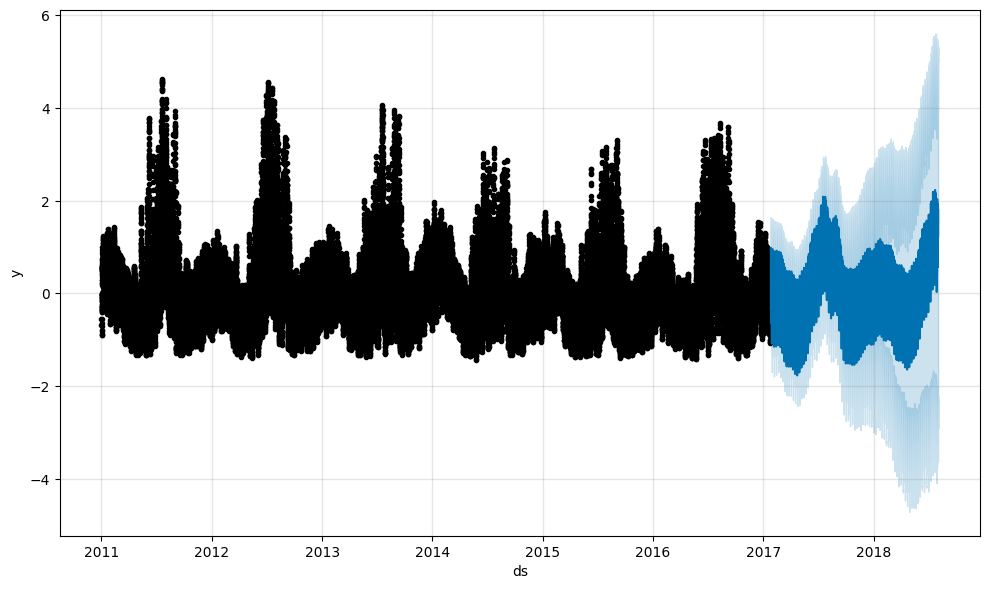

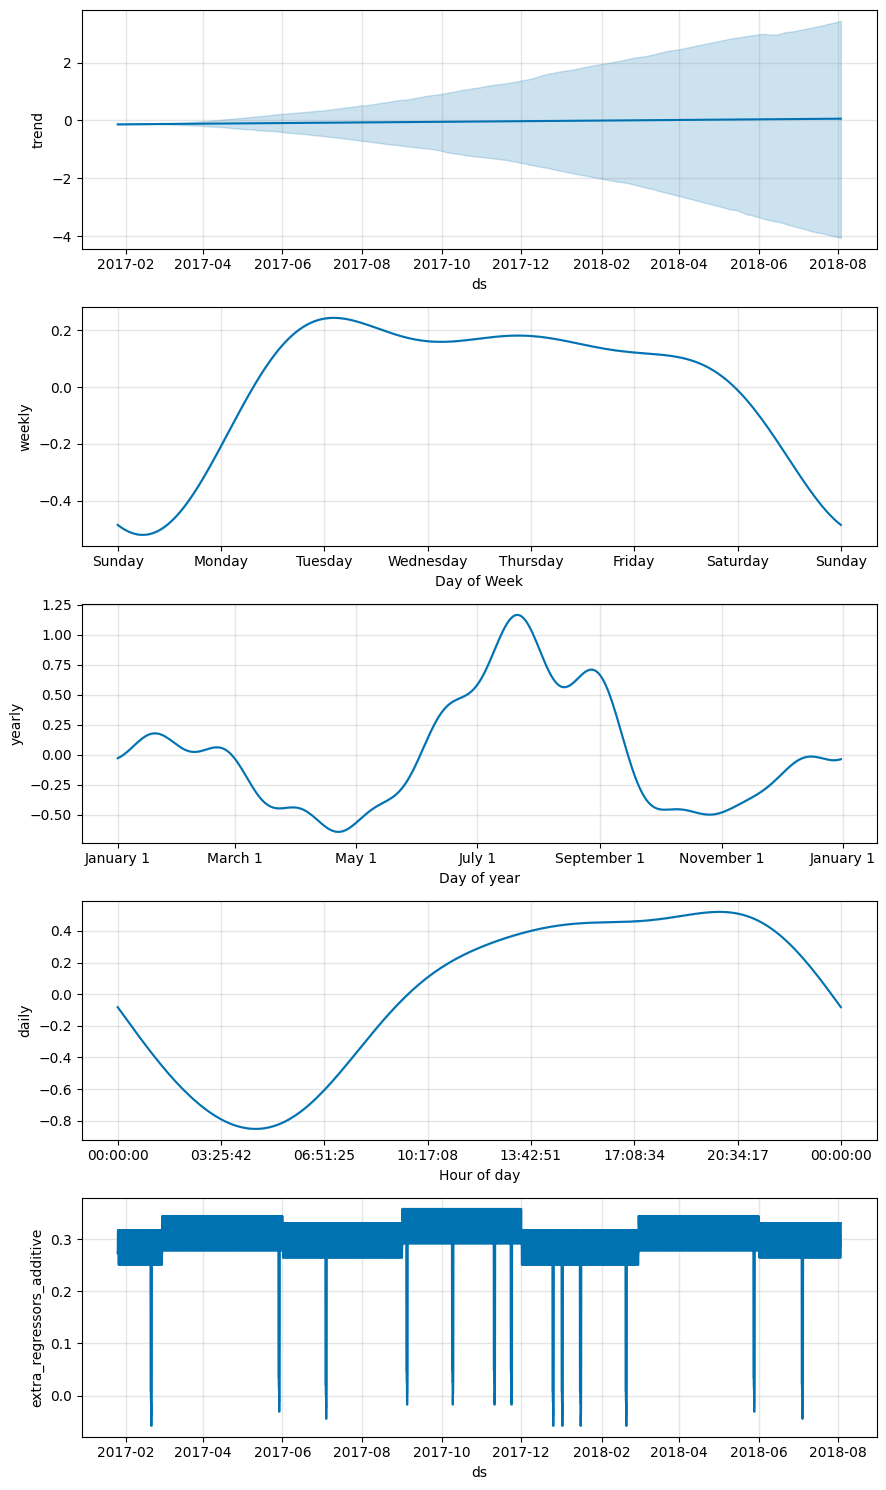

In [7]:
from prophet import Prophet

train = train.rename(columns={'Datetime': 'ds', 'COMED_MW_scaled': 'y'})
train['ds'] = pd.to_datetime(train['ds'])

test = test.rename(columns={'Datetime': 'ds', 'COMED_MW_scaled': 'y'})
test['ds'] = pd.to_datetime(test['ds'])

model = Prophet()

# Adding regressors to the model to improve the forecast
model.add_regressor('Season_encoded')
model.add_regressor('Time_of_day_encoded')
model.add_regressor('Holiday_encoded')

model.fit(train)

# Create a future DataFrame based on the test set dates
future = test[['ds', 'Season_encoded', 'Time_of_day_encoded', 'Holiday_encoded']]

# Predict future values
forecast = model.predict(future)

fig1 = model.plot(forecast)

fig2 = model.plot_components(forecast)


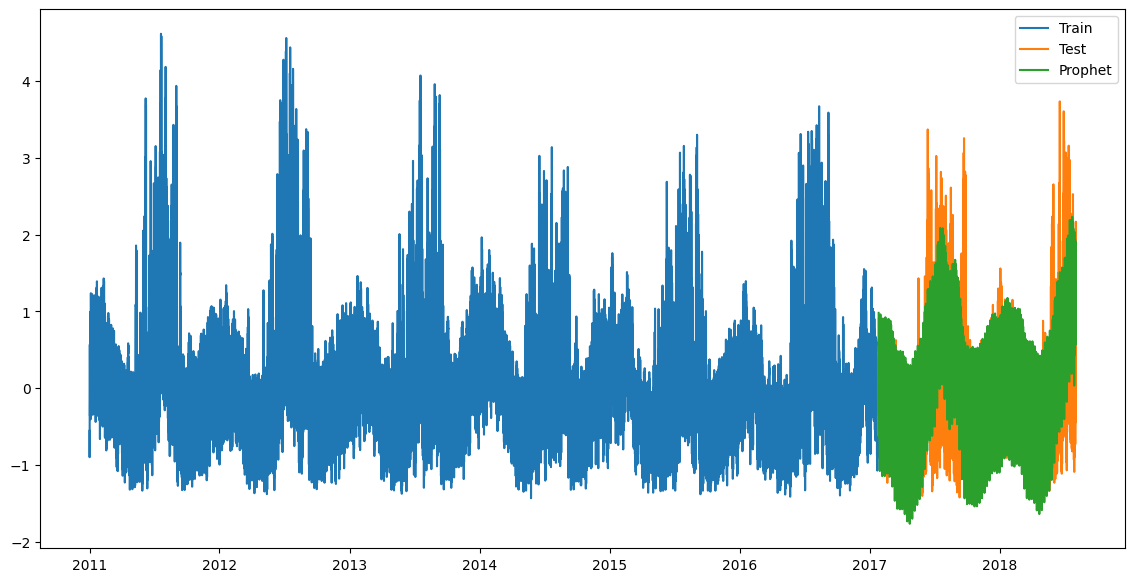

In [8]:
#plot the predictions as a continued line starting from the train data
plt.figure(figsize=(14, 7))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], forecast['yhat'], label='Prophet')
plt.legend()
plt.show()

In [9]:
#calculate MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['y'], forecast['yhat'])
print('MAE: %.3f' % mae)
#calculate MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['y'], forecast['yhat'])
print('MSE: %.3f' % mse)
#calculate r2 score
from sklearn.metrics import r2_score
r2 = r2_score(test['y'], forecast['yhat'])
print('R2: %.3f' % r2)

MAE: 0.478
MSE: 0.376
R2: 0.417


In [11]:
# save the model to disk
import pickle
filename = 'prophet.pkl'
pickle.dump(model, open(filename, 'wb'))

In [1]:
import pickle
filename = '/home/hashim/Assignments/Sem6/DataMining/DM_Proj/models/prophet.pkl'
model = pickle.load(open(filename, 'rb'))

/home/hashim/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [39]:
import pandas as pd
import pickle

filename = '/home/hashim/Assignments/Sem6/DataMining/DM_Proj/models/prophet.pkl'
model = pickle.load(open(filename, 'rb'))

df = pd.read_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/COMED_hourly_preprocessed.csv')

train = df.iloc[:int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]

train = train.rename(columns={'Datetime': 'ds', 'COMED_MW_scaled': 'y'})
train['ds'] = pd.to_datetime(train['ds'])

test = test.rename(columns={'Datetime': 'ds'})
test['ds'] = pd.to_datetime(test['ds'])

test_for_prediction = test[['ds', 'Season_encoded', 'Time_of_day_encoded', 'Holiday_encoded']]

forecast = model.predict(test_for_prediction)

print("Preview of predictions:", forecast[['ds', 'yhat']].head())

test['Predictions'] = forecast['yhat'].values  # Direct assignment of predictions to ensure alignment


Preview of predictions:                    ds      yhat
0 2017-01-25 20:00:00  0.979972
1 2017-01-25 21:00:00  0.945332
2 2017-01-25 22:00:00  0.872301
3 2017-01-25 23:00:00  0.671608
4 2017-01-26 00:00:00  0.418492


In [41]:
final = pd.concat([train, test])
final.loc[final.index[len(train):], 'Predictions'] = forecast['yhat'].values
final = final.rename(columns={'ds': 'Datetime', 'y': 'COMED_MW_scaled'})
final.to_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/Prophet_Predictions.csv', index=False)